In [31]:
cd /orange/adamginsburg/salt/sanhueza/G34.43

/orange/adamginsburg/salt/sanhueza/G34.43


In [32]:
ls

cutout.reg
G34.43+0.24.config8.cont_avg.selfcal_0.5_hogbom.image.fits
G34.43+0.24.config8.spw0.robust0.5.image_co1_smaller.fits
G34.43+0.24.config8.spw0.robust0.5.image_small.fits
G34.43+0.24.config8.spw1.robust0.5.image_co1_smaller.fits
G34.43+0.24.config8.spw1.robust0.5.image_small.fits
G34.43+0.24.config8.spw2.robust0.5.image_co1_smaller.fits
G34.43+0.24.config8.spw2.robust0.5.image_small.fits
G34.43+0.24.config8.spw3.robust0.5.image_co1_smaller.fits
G34.43+0.24.config8.spw3.robust0.5.image_small.fits
NaCl_v_le_3_stackcube.fits


In [33]:
targetname = 'G34.43+0.24'

for fn in glob.glob("*.fits"):
    print('app

In [34]:
%matplotlib inline
import pylab as pl
pl.rcParams['figure.facecolor'] = 'w'
from spectral_cube import SpectralCube
from astropy import units as u
from astropy.visualization import quantity_support
quantity_support()

<astropy.visualization.units.quantity_support.<locals>.MplQuantityConverter at 0x2b081f174dc0>

In [35]:
from astropy.table import Table
from astropy import table

In [36]:
import pprint

In [37]:
import scipy, scipy.ndimage

In [38]:
import numpy as np
import os
import glob
from astropy import constants, units as u, table, stats, coordinates, wcs, log, coordinates as coord
import radio_beam
import pyspeckit
import pylab as pl
from astroquery.splatalogue.utils import minimize_table as mt
import sys
sys.path.append('/orange/adamginsburg/salt/Orion_ALMA_2016.1.00165.S/analysis')
import lines
import paths
from salt_tables import (salt_tables, salt_table_names, SO, SO2, HCl, sis_tables, AlCl, AlF, Al37Cl,
                         NaF, AlO, AlOH, NaCN, CaS, CaO)

In [39]:
import regions
from astropy import units as u, coordinates
reg = regions.Regions.read('cutout.reg')
#reg2 = regions.Regions.read('cutout2.reg')
#reg3 = regions.Regions.read('cutout3.reg')
#regvsm = regions.Regions.read('verysmall.reg')
#regvvsm = regions.Regions.read('innerdiskbox.reg')

In [40]:
reg[0].center.galactic

<SkyCoord (Galactic): (l, b) in deg
    (34.41132396, 0.23491391)>

# NaCl Stackl

In [41]:
from spectral_cube.analysis_utilities import stack_cube

In [42]:
nacltables = salt_tables[3:5]
#nacltables[0]

In [43]:
import spectral_cube.analysis_utilities
import imp
imp.reload(spectral_cube.analysis_utilities)
from spectral_cube.analysis_utilities import stack_cube

In [44]:
flist = (glob.glob(f'{targetname}.config8.spw[0-3].robust0.5.image_small.fits'))

In [45]:
flist

['G34.43+0.24.config8.spw3.robust0.5.image_small.fits',
 'G34.43+0.24.config8.spw2.robust0.5.image_small.fits',
 'G34.43+0.24.config8.spw0.robust0.5.image_small.fits',
 'G34.43+0.24.config8.spw1.robust0.5.image_small.fits']

In [46]:
#from dask.diagnostics import ProgressBar
#pbar = ProgressBar()
#pbar.register()

import dask
dask.config.set(scheduler='threads', num_workers=8)

In [47]:
for fn in flist:
    for rr,regn in ( (reg, 'co1'), ):
        outfile = fn.replace("_small",f"_{regn}_smaller")
        if not os.path.exists(outfile):
            cube = SpectralCube.read(fn, use_dask=False).subcube_from_regions(rr)
            cube.allow_huge_operations=True
            #with cube.use_dask_scheduler('threads', num_workers=8):
            cb = cube.beams.common_beam(max_iter=20, max_epsilon=0.01)
            scube = cube.convolve_to(cb)
            scube.write(outfile)

In [48]:
regn = "co1"
# don't need to subcube b/c reg = cutout = co1
cubes = [SpectralCube.read(fn, use_dask=True)#.subcube_from_regions(reg3)
         for fn in (glob.glob(f'{targetname}.config8.spw[0-3].robust0.5.image_{regn}_smaller.fits'))]
for ii,cube in enumerate(cubes):
    # continuum subtract
    with cube.use_dask_scheduler('threads', num_workers=8):
        cube.allow_huge_operations = True
        cubes[ii] = cube - cube.percentile(25, axis=0)
cubes

[DaskSpectralCube with shape=(3866, 50, 52) and unit=Jy / beam and chunk size (3866, 50, 52):
  n_x:     52  type_x: RA---SIN  unit_x: deg    range:   283.324967 deg:  283.325151 deg
  n_y:     50  type_y: DEC--SIN  unit_y: deg    range:     1.423664 deg:    1.423841 deg
  n_s:   3866  type_s: FREQ      unit_s: Hz     range: 219062738860.000 Hz:220949992551.736 Hz,
 DaskSpectralCube with shape=(3866, 50, 52) and unit=Jy / beam and chunk size (3866, 50, 52):
  n_x:     52  type_x: RA---SIN  unit_x: deg    range:   283.324967 deg:  283.325151 deg
  n_y:     50  type_y: DEC--SIN  unit_y: deg    range:     1.423664 deg:    1.423841 deg
  n_s:   3866  type_s: FREQ      unit_s: Hz     range: 216862738681.100 Hz:218749992372.836 Hz,
 DaskSpectralCube with shape=(1933, 50, 52) and unit=Jy / beam and chunk size (1933, 50, 52):
  n_x:     52  type_x: RA---SIN  unit_x: deg    range:   283.324967 deg:  283.325151 deg
  n_y:     50  type_y: DEC--SIN  unit_y: deg    range:     1.423664 deg:    1.423

In [49]:
# only needed for VRSCs
if hasattr(cubes[0], 'beams'):
    beams = radio_beam.Beams(beams=[cube.beams.common_beam(max_iter=20, max_epsilon=0.01) for cube in cubes])
    cb=beams.common_beam()
else:
    beams = radio_beam.Beams(beams=[cube.beam for cube in cubes])
    cb=beams.common_beam()

In [50]:
linelist = np.concatenate([data['Freq'][(data['vu'] <= 3) &
                                          np.any([((data['Freq'].quantity > cube.spectral_extrema[0]) &
                                                   (data['Freq'].quantity < cube.spectral_extrema[1]))
                                                 for cube in cubes],
                                                 axis=0)].quantity
                             for data in nacltables])
linenames = np.concatenate( [data['Species'][(data['vu'] <= 3) &
                                          np.any([((data['Freq'].quantity > cube.spectral_extrema[0]) &
                                                   (data['Freq'].quantity < cube.spectral_extrema[1]))
                                                 for cube in cubes],
                                                 axis=0)]
                             for data in nacltables] )
(linelist, linenames)

(<Quantity [217.980231, 219.614936, 232.509977, 234.251912] GHz>,
 array(['23Na-35Clv=2-2 J=17-16', '23Na-35Clv=1-1 J=17-16',
        '23Na-35Clv=1-1 J=18-17', '23Na-35Clv=0-0 J=18-17'], dtype='<U24'))

In [51]:
from astropy import log
log.setLevel('INFO')

In [52]:
#log.setLevel('DEBUG')
vcen = 57.6 * u.km/u.s # from Patricio
stack, cutouts = stack_cube(cubes,
                   linelist=linelist,
                   vmin=vcen-25*u.km/u.s,
                   vmax=vcen+25*u.km/u.s,
                   average=np.nanmean,
                   convolve_beam=cb,
                   return_cutouts=True)
#log.setLevel('INFO')
stack.write('NaCl_v_le_3_stackcube.fits', overwrite=True)

In [53]:
stackc = SpectralCube.read('NaCl_v_le_3_stackcube.fits')
stackc

SpectralCube with shape=(75, 50, 52) and unit=Jy / beam:
 n_x:     52  type_x: RA---SIN  unit_x: deg    range:   283.324967 deg:  283.325151 deg
 n_y:     50  type_y: DEC--SIN  unit_y: deg    range:     1.423664 deg:    1.423841 deg
 n_s:     75  type_s: VRAD      unit_s: km / s  range:       32.616 km / s:      82.311 km / s

In [54]:
232.6867*(1-vcen/constants.c).decompose()

<Quantity 232.64199323>

In [55]:
pl.rcParams['image.origin'] = 'lower'

DaskSpectralCube with shape=(1933, 50, 52) and unit=Jy / beam and chunk size (1933, 50, 52):
 n_x:     52  type_x: RA---SIN  unit_x: deg    range:   283.324967 deg:  283.325151 deg
 n_y:     50  type_y: DEC--SIN  unit_y: deg    range:     1.423664 deg:    1.423841 deg
 n_s:   1933  type_s: FREQ      unit_s: Hz     range: 231062983982.800 Hz:232949749381.214 Hz
DaskSpectralCube with shape=(33, 50, 52) and unit=Jy / beam and chunk size (33, 50, 52):
 n_x:     52  type_x: RA---SIN  unit_x: deg    range:   283.324967 deg:  283.325151 deg
 n_y:     50  type_y: DEC--SIN  unit_y: deg    range:     1.423664 deg:    1.423841 deg
 n_s:     33  type_s: VRAD      unit_s: km / s  range:       37.299 km / s:      77.562 km / s


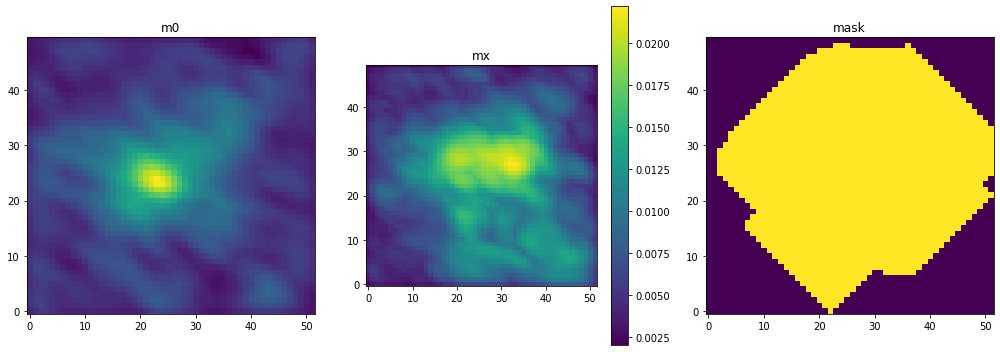

<Figure size 432x288 with 0 Axes>

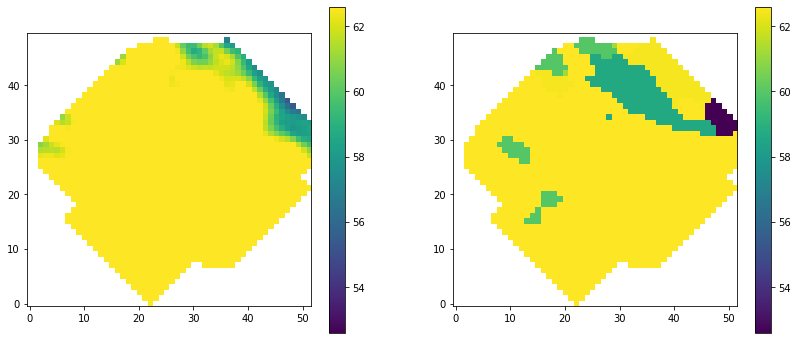

In [56]:
# try creating a vmap based on another line (water)
restval = 232.6867*u.GHz # 'H2Ov2=1_5(5,0)-6(4,3)': 
cube = [c for c in cubes if (c.spectral_extrema[0] < restval) & (c.spectral_extrema[1] > restval)][0]
print(cube)
scube = (cube.subcube_from_regions(reg)
         .with_spectral_unit(u.km/u.s,
                                                          velocity_convention='radio',
                                                          rest_value=restval)
         .spectral_slab(-20*u.km/u.s+vcen, 20*u.km/u.s+vcen))
print(scube)
pl.figure(figsize=(14,5))
pl.subplot(1,3,1)
m0 = scube.moment0()
m0.quicklook()
pl.title("m0")

pl.subplot(1,3,2)
mx = scube.max(axis=0)
mx.quicklook()
pl.title("mx")
pl.colorbar()
pl.subplot(1,3,3)
msk = mx > 0.015*mx.unit
#msk = scipy.ndimage.binary_erosion(msk, iterations=1)
msk = scipy.ndimage.binary_dilation(msk, iterations=14)
pl.imshow(msk, interpolation='none', origin='lower')
pl.title('mask')
pl.tight_layout()
pl.figure()


m1 = scube.with_mask(msk).with_mask(scube > 0.0001*stackc.unit).moment1()
pl.figure(figsize=(14,6))
ax1 = pl.subplot(1,2,1)
im = ax1.imshow(m1.value, vmin=vcen.value-5, vmax=vcen.value+5)
pl.colorbar(mappable=im)
mxv = scube.with_mask(msk).argmax_world(axis=0)
pl.subplot(1,2,2)
pl.imshow(mxv.value, vmin=vcen.value-5, vmax=vcen.value+5)
pl.colorbar()


vmap = m1.hdu
# the rest value selected above was just the line center; we need to assume it's really 32 km/s off
#vmap.data = vmap.data

DaskSpectralCube with shape=(3866, 50, 52) and unit=Jy / beam and chunk size (3866, 50, 52):
 n_x:     52  type_x: RA---SIN  unit_x: deg    range:   283.324967 deg:  283.325151 deg
 n_y:     50  type_y: DEC--SIN  unit_y: deg    range:     1.423664 deg:    1.423841 deg
 n_s:   3866  type_s: FREQ      unit_s: Hz     range: 216862738681.100 Hz:218749992372.836 Hz
DaskSpectralCube with shape=(61, 50, 52) and unit=Jy / beam and chunk size (61, 50, 52):
 n_x:     52  type_x: RA---SIN  unit_x: deg    range:   283.324967 deg:  283.325151 deg
 n_y:     50  type_y: DEC--SIN  unit_y: deg    range:     1.423664 deg:    1.423841 deg
 n_s:     61  type_s: VRAD      unit_s: km / s  range:       37.365 km / s:      77.689 km / s


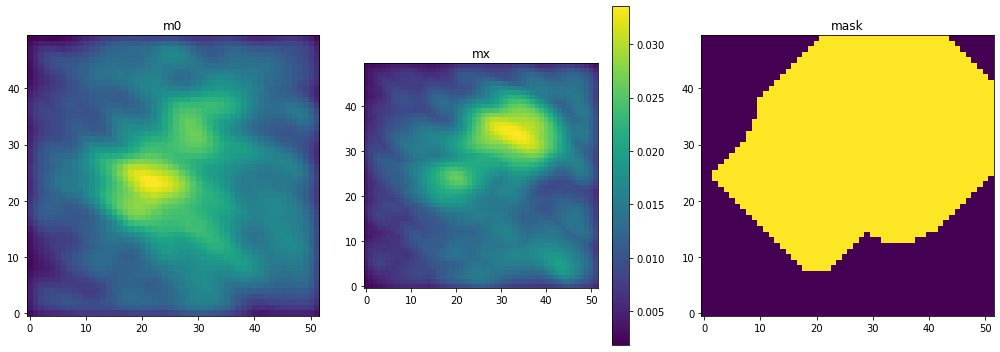

<Figure size 432x288 with 0 Axes>

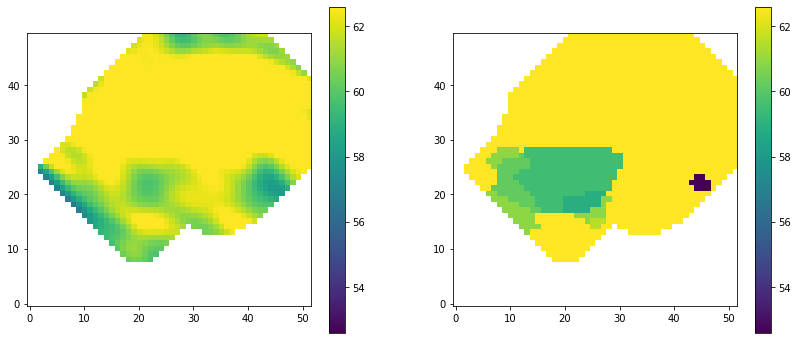

In [57]:
# try creating a vmap based on another line (SiS 12-11)
restval = 217.81764400*u.GHz # '': 
cube = [c for c in cubes if (c.spectral_extrema[0] < restval) & (c.spectral_extrema[1] > restval)][0]
print(cube)
scube = (cube.subcube_from_regions(reg)
         .with_spectral_unit(u.km/u.s,
                             velocity_convention='radio',
                             rest_value=restval)
         .spectral_slab(-20*u.km/u.s+vcen, 20*u.km/u.s+vcen))
print(scube)
pl.figure(figsize=(14,5))
pl.subplot(1,3,1)
m0 = scube.moment0()
m0.quicklook()
pl.title("m0")

pl.subplot(1,3,2)
mx = scube.max(axis=0)
mx.quicklook()
pl.title("mx")
pl.colorbar()
pl.subplot(1,3,3)
msk = mx > 0.022*mx.unit
#msk = scipy.ndimage.binary_erosion(msk, iterations=1)
msk = scipy.ndimage.binary_dilation(msk, iterations=14)
pl.imshow(msk, interpolation='none', origin='lower')
pl.title('mask')
pl.tight_layout()
pl.figure()


m1 = scube.with_mask(msk).with_mask(scube > 0.0001*stackc.unit).moment1()
pl.figure(figsize=(14,6))
ax1 = pl.subplot(1,2,1)
im = ax1.imshow(m1.value, vmin=vcen.value-5, vmax=vcen.value+5)
pl.colorbar(mappable=im)
mxv = scube.with_mask(msk).argmax_world(axis=0)
pl.subplot(1,2,2)
pl.imshow(mxv.value, vmin=vcen.value-5, vmax=vcen.value+5)
pl.colorbar()


#vmap = m1.hdu

invalid value encountered in true_divide


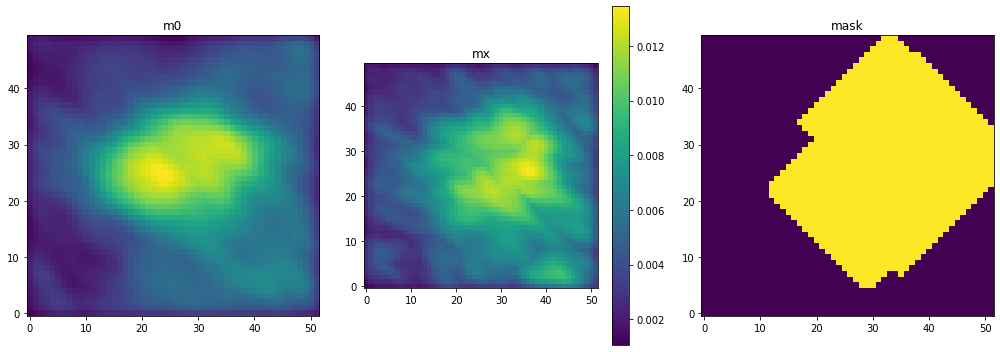

<Figure size 432x288 with 0 Axes>

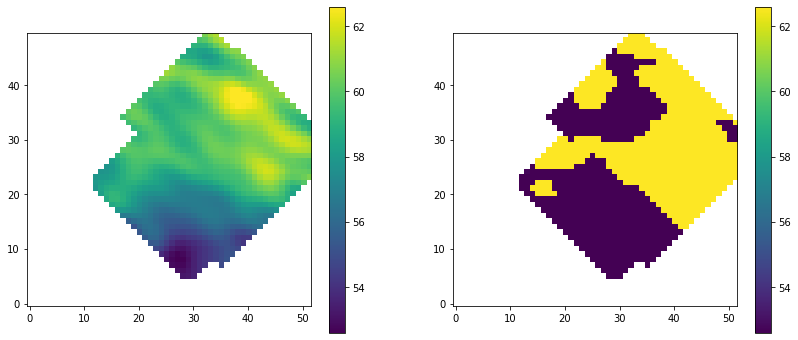

In [59]:
stackc = stackc.subcube_from_regions(reg)
pl.figure(figsize=(14,5))
pl.subplot(1,3,1)
m0 = stackc.moment0()
m0.quicklook()
pl.title("m0")

pl.subplot(1,3,2)
mx = stackc.max(axis=0)
mx.quicklook()
pl.title("mx")
pl.colorbar()
pl.subplot(1,3,3)
msk = mx > 0.0115*mx.unit
msk = scipy.ndimage.binary_erosion(msk, iterations=1)
msk = scipy.ndimage.binary_dilation(msk, iterations=15)
pl.imshow(msk, interpolation='none', origin='lower')
pl.title('mask')
pl.tight_layout()
pl.figure()


m1 = stackc.with_mask(msk).with_mask(stackc > 0.0001*stackc.unit).moment1()
pl.figure(figsize=(14,6))
ax1 = pl.subplot(1,2,1)
im = ax1.imshow(m1.value, vmin=vcen.value-5, vmax=vcen.value+5)
pl.colorbar(mappable=im)
mxv = stackc.with_mask(msk).argmax_world(axis=0)
pl.subplot(1,2,2)
pl.imshow(mxv.value, vmin=vcen.value-5, vmax=vcen.value+5)
pl.colorbar()


vmap = m1.hdu

In [60]:
import sys
sys.path.append('/orange/adamginsburg/salt/code/')
from overplot_saltlines import overplot_saltlines

In [61]:
spectra = []
for ii,cube in enumerate(cubes):
    cube.allow_huge_operations=True
    sp = cube.subcube_from_regions(reg).mean(axis=(1,2))
    pysp = pyspeckit.Spectrum(data=sp, xarr=sp.spectral_axis, header=sp.header)
    spectra.append(pysp)
    pysp.specname = f'spw{ii+1}'

In [62]:
mkdir -p spectra/figures

spw1
spw2
spw3


spw4


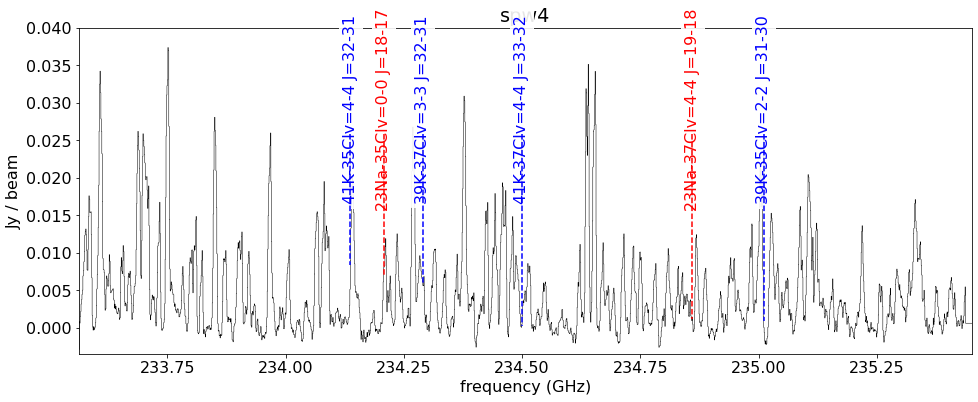

In [63]:
overplot_saltlines(spectra, vcen=vcen, savepath='spectra/figures')

In [64]:
ls spectra/figures

color_labels_spw1.png  color_labels_spw3.png  spw1.png  spw3.png
color_labels_spw2.png  color_labels_spw4.png  spw2.png  spw4.png


In [65]:
from IPython.display import Image,display

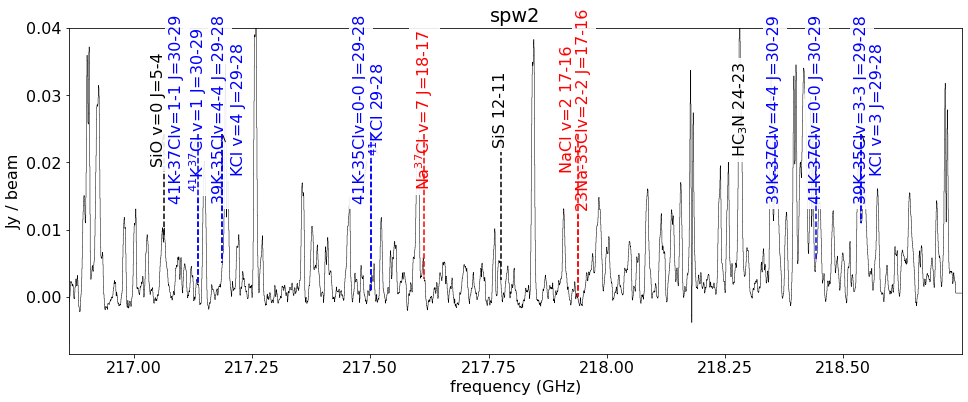

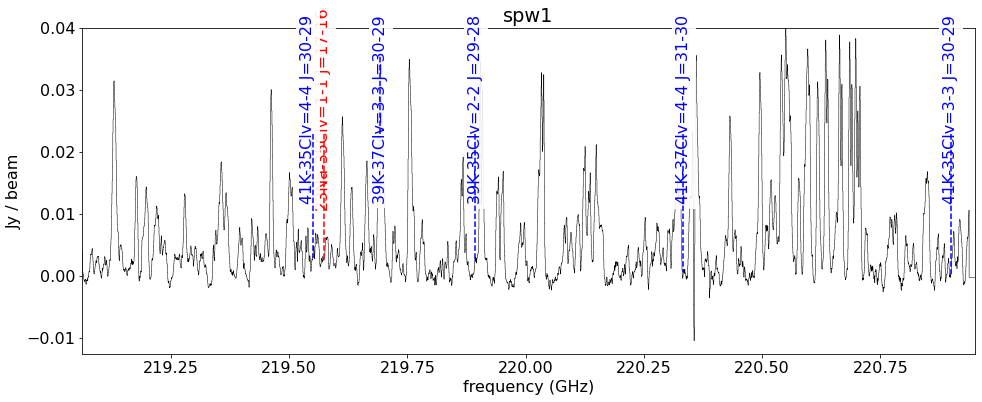

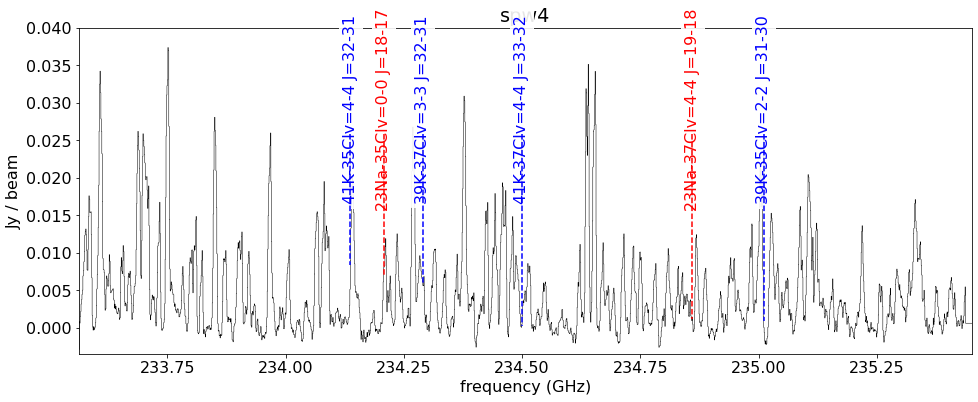

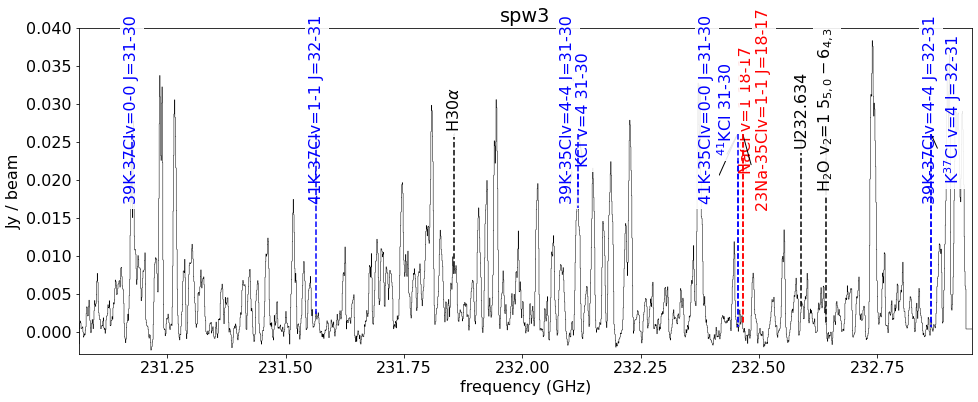

In [66]:
for fn in glob.glob('spectra/figures/color*png'):
    display(Image(fn))

G34.43+0.24.config8.spw3.robust0.5.image_co1_smaller
DaskSpectralCube with shape=(3866, 50, 52) and unit=Jy / beam and chunk size (3866, 50, 52):
 n_x:     52  type_x: RA---SIN  unit_x: deg    range:   283.324967 deg:  283.325151 deg
 n_y:     50  type_y: DEC--SIN  unit_y: deg    range:     1.423664 deg:    1.423841 deg
 n_s:   3866  type_s: FREQ      unit_s: Hz     range: 219062738860.000 Hz:220949992551.736 Hz


Mean spectrum
Stacking
G34.43+0.24.config8.spw2.robust0.5.image_co1_smaller
DaskSpectralCube with shape=(3866, 50, 52) and unit=Jy / beam and chunk size (3866, 50, 52):
 n_x:     52  type_x: RA---SIN  unit_x: deg    range:   283.324967 deg:  283.325151 deg
 n_y:     50  type_y: DEC--SIN  unit_y: deg    range:     1.423664 deg:    1.423841 deg
 n_s:   3866  type_s: FREQ      unit_s: Hz     range: 216862738681.100 Hz:218749992372.836 Hz


Mean spectrum
Stacking
G34.43+0.24.config8.spw1.robust0.5.image_co1_smaller
DaskSpectralCube with shape=(1933, 50, 52) and unit=Jy / beam and chunk size (1933, 50, 52):
 n_x:     52  type_x: RA---SIN  unit_x: deg    range:   283.324967 deg:  283.325151 deg
 n_y:     50  type_y: DEC--SIN  unit_y: deg    range:     1.423664 deg:    1.423841 deg
 n_s:   1933  type_s: FREQ      unit_s: Hz     range: 231062983982.800 Hz:232949749381.214 Hz


Mean spectrum
Stacking
G34.43+0.24.config8.spw0.robust0.5.image_co1_smaller
DaskSpectralCube with shape=(1934, 50, 52) and unit=Jy / beam and chunk size (1934, 50, 52):
 n_x:     52  type_x: RA---SIN  unit_x: deg    range:   283.324967 deg:  283.325151 deg
 n_y:     50  type_y: DEC--SIN  unit_y: deg    range:     1.423664 deg:    1.423841 deg
 n_s:   1934  type_s: FREQ      unit_s: Hz     range: 233562984186.100 Hz:235450726171.041 Hz


Mean spectrum
Stacking


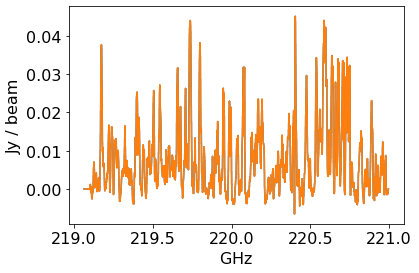

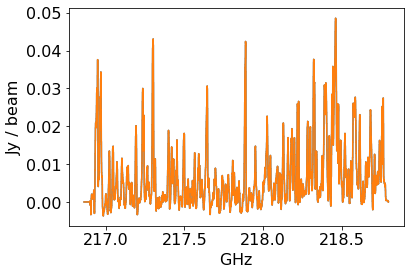

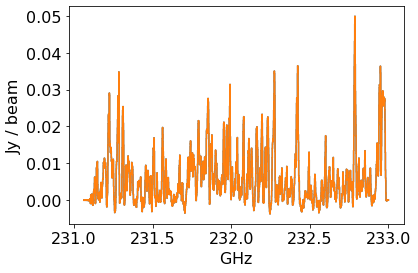

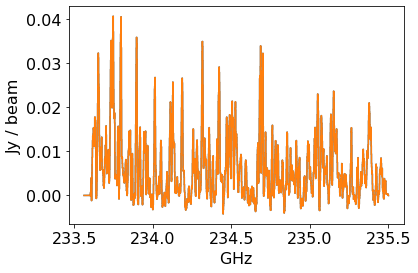

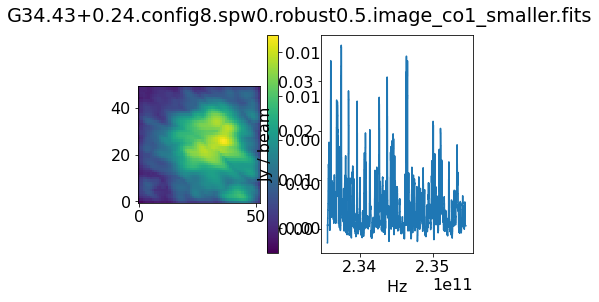

In [67]:
import glob
import spectral_cube.analysis_utilities
import reproject
from tqdm.notebook import tqdm


cbflist = (glob.glob(f'{targetname}.config8.spw[0-3].robust0.5.image_co1_smaller.fits'))
for fn in cbflist:
    basename = os.path.split(fn)[-1].split(".fits")[0]
    print(basename)
    try:
        cube = SpectralCube.read(fn, use_dask=True)
    except Exception as ex:
        print(ex)
        continue
    print(cube)
    scube = cube.subcube_from_regions(reg)
    # continuum subtract before stacking
    scube = scube - scube.percentile(25, axis=0)
    #mx = scube.max(axis=0)
    #msk = mx > 0.003*mx.unit
    print("Mean spectrum")
    sp = scube.mean(axis=(1,2))
    
    sp.write(f'spectra/{fn.split("/")[-1].replace(".fits","_meanspec.fits")}', overwrite=True)


    # reproject the velocity map into the cube's coordinate system
    vmap_proj,_ = reproject.reproject_interp(vmap,
                                             scube.wcs.celestial,
                                             shape_out=scube.shape[1:])
    vmap_proj = u.Quantity(vmap_proj, u.km/u.s)

    # convert to km/s with arbitrary rest value so 0 km/s can be interpreted
    if scube.spectral_axis.unit.is_equivalent(u.Hz):
        scube = scube.with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=scube.spectral_axis.mean())

    print("Stacking")
    # perform the stacking!
    stack = spectral_cube.analysis_utilities.stack_spectra(scube, vmap_proj,
                                                           v0=0.0*u.km/u.s,
                                                           #progressbar=tqdm,
                                                           #num_cores=8
                                                          )
    fstack = stack.with_spectral_unit(u.GHz)

    pl.suptitle(f"{fn}")
    fstack.write(f'spectra/{basename}_stack.fits', overwrite=True)

    pl.clf()
    fstack.quicklook(filename=f'spectra/figures/{basename}_stack.pdf')
    fstack.quicklook(filename=f'spectra/figures/{basename}_stack.png')
    
    
    fig = pl.figure()
    mappable = pl.subplot(1,2,1).imshow(mx.value, origin='lower', interpolation='none')
    pl.colorbar(mappable)
    pl.subplot(1,2,2)
    pl.suptitle(fn)
    sp.quicklook()

In [68]:
ls spectra

figures/
G34.43+0.24.config8.spw0.robust0.5.image_co1_smaller_meanspec.fits
G34.43+0.24.config8.spw0.robust0.5.image_co1_smaller_stack.fits
G34.43+0.24.config8.spw1.robust0.5.image_co1_smaller_meanspec.fits
G34.43+0.24.config8.spw1.robust0.5.image_co1_smaller_stack.fits
G34.43+0.24.config8.spw2.robust0.5.image_co1_smaller_meanspec.fits
G34.43+0.24.config8.spw2.robust0.5.image_co1_smaller_stack.fits
G34.43+0.24.config8.spw3.robust0.5.image_co1_smaller_meanspec.fits
G34.43+0.24.config8.spw3.robust0.5.image_co1_smaller_stack.fits


In [69]:
stackspectra = []
for ii,fn in enumerate(glob.glob('spectra/*_stack.fits')):
    pysp = pyspeckit.Spectrum(fn)
    basename = os.path.basename(fn)
    spl = basename.split(".")
    pysp.specname = f'{spl[0]}_{spl[4]}_stack'
    stackspectra.append(pysp)

G34_spw1_stack


G34_spw0_stack


G34_spw2_stack
G34_spw3_stack


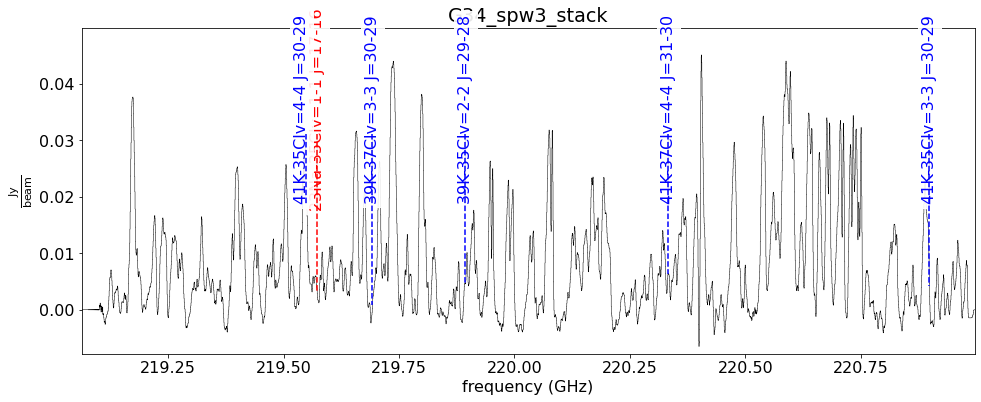

In [70]:
overplot_saltlines(stackspectra, vcen=vcen, savepath='spectra/figures')

In [71]:
ls spectra/figures/

color_labels_G34_spw0_stack.png
color_labels_G34_spw1_stack.png
color_labels_G34_spw2_stack.png
color_labels_G34_spw3_stack.png
color_labels_spw1.png
color_labels_spw2.png
color_labels_spw3.png
color_labels_spw4.png
G34.43+0.24.config8.spw0.robust0.5.image_co1_smaller_stack.pdf
G34.43+0.24.config8.spw0.robust0.5.image_co1_smaller_stack.png
G34.43+0.24.config8.spw1.robust0.5.image_co1_smaller_stack.pdf
G34.43+0.24.config8.spw1.robust0.5.image_co1_smaller_stack.png
G34.43+0.24.config8.spw2.robust0.5.image_co1_smaller_stack.pdf
G34.43+0.24.config8.spw2.robust0.5.image_co1_smaller_stack.png
G34.43+0.24.config8.spw3.robust0.5.image_co1_smaller_stack.pdf
G34.43+0.24.config8.spw3.robust0.5.image_co1_smaller_stack.png
G34_spw0_stack.png
G34_spw1_stack.png
G34_spw2_stack.png
G34_spw3_stack.png
spw1.png
spw2.png
spw3.png
spw4.png


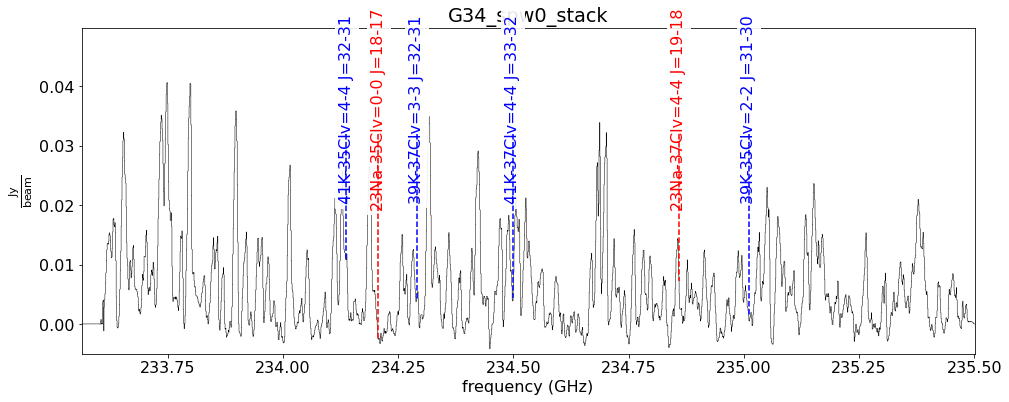

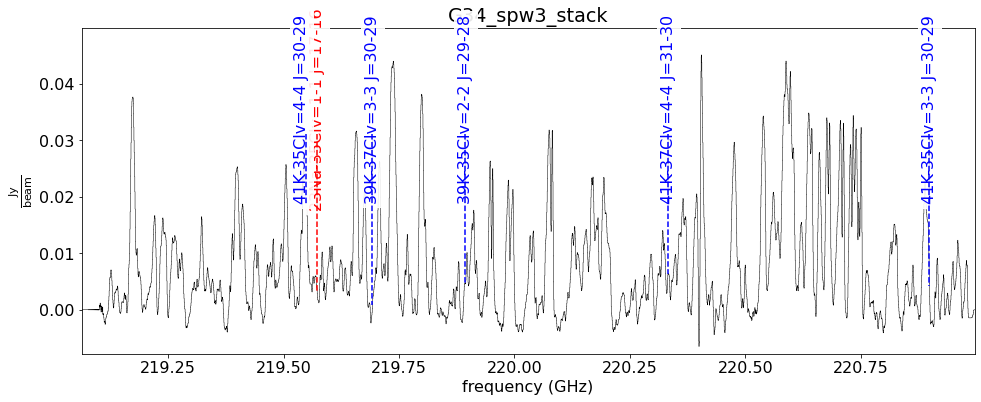

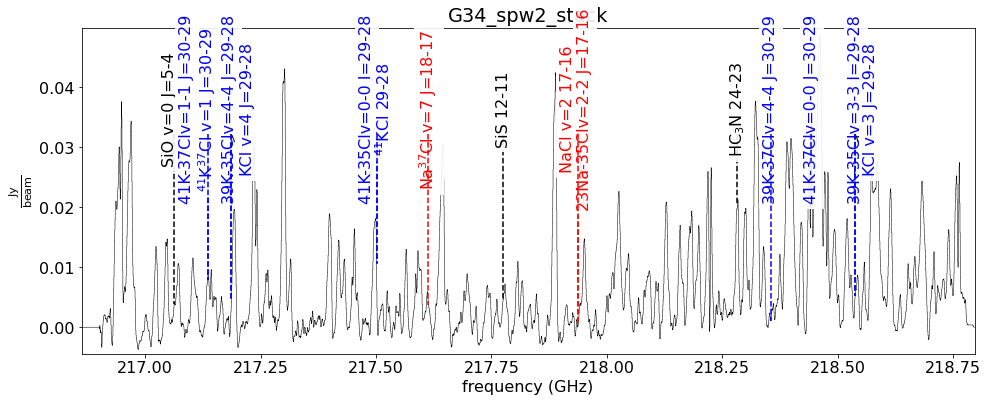

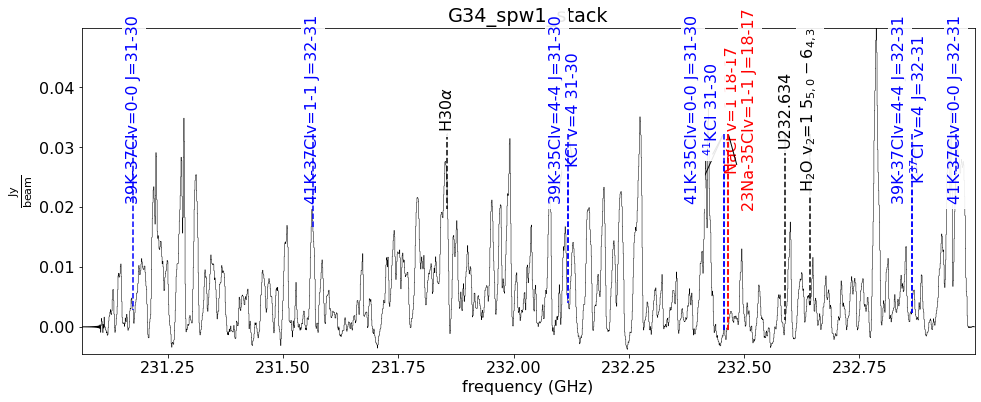

In [72]:
for fn in glob.glob('spectra/figures/color*stack.png'):
    display(Image(fn))